In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# nltk.download('punkt')
# nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))
words_to_keep = {'dan', 'dengan'}
custom_stopwords = {word for word in stop_words if word not in words_to_keep}

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocess_text(text):
    text = text.lower()
    
    tokens = word_tokenize(text)
    
    processed_tokens = [stemmer.stem(word) for word in tokens 
                       if word.isalnum() and word not in custom_stopwords]
    
    return ' '.join(processed_tokens)

train_data = pd.read_csv('train_dataset.csv')
data = pd.read_csv('table-obat2.csv')

train_data['Query'] = train_data['Query'].apply(preprocess_text)
data['Indication'] = data['Indikasi'].apply(preprocess_text)
data['Dosage'] = data['Dosis'].apply(preprocess_text)
data['Contraindications'] = data['Kontraindikasi'].apply(preprocess_text)
data['Side_Effects'] = data['Efek_Samping'].apply(preprocess_text)
data['Interaction'] = data['Interaksi'].apply(preprocess_text)

combined_corpus = pd.concat([train_data['Query'], 
                           data['Indication'], 
                           data['Dosage'], 
                           data['Contraindications'], 
                           data['Side_Effects'], 
                           data['Interaction']], 
                           axis=0)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.width', None)

# print(combined_corpus)

rf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    strip_accents='unicode',
    sublinear_tf=True
)

svm_vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),  
    min_df=3,  
    max_df=0.90,
    strip_accents='unicode',
    sublinear_tf=True
)

nb_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.98,
    strip_accents='unicode',
    sublinear_tf=True
)

lr_vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),  
    min_df=2,  
    max_df=0.95,
    strip_accents='unicode',
    sublinear_tf=True
)

rf_vectorizer.fit(combined_corpus)
svm_vectorizer.fit(train_data['Query'])
nb_vectorizer.fit(train_data['Query'])
lr_vectorizer.fit(train_data['Query'])

# tfidf_matrix = vectorizer.transform(train_data['Query'])
# tfidf_df = pd.DataFrame(tfidf_matrix.toarray())

# print("SVM TF-IDF : ")
# print(tfidf_df)

X_train, X_test, y_train, y_test = train_test_split(
    train_data['Query'], 
    train_data['Label'], 
    test_size=0.2, 
    random_state=42,
    stratify=train_data['Label']
)

X_train_rf = rf_vectorizer.transform(X_train)
X_test_rf = rf_vectorizer.transform(X_test)

X_train_svm = svm_vectorizer.transform(X_train)
X_test_svm = svm_vectorizer.transform(X_test)

X_train_nb = nb_vectorizer.transform(X_train)
X_test_nb = nb_vectorizer.transform(X_test)

X_train_lr = lr_vectorizer.transform(X_train)
X_test_lr = lr_vectorizer.transform(X_test)

rf_params = {
    'n_estimators': [200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

rf_classifier = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_classifier, rf_params, cv=5, n_jobs=-1)
rf_grid.fit(X_train_rf, y_train)
rf_classifier = rf_grid.best_estimator_

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'class_weight': ['balanced'],
    'probability': [True]
}

svm_classifier = SVC()
svm_grid = GridSearchCV(svm_classifier, svm_params, cv=5, n_jobs=-1)
svm_grid.fit(X_train_svm, y_train)
svm_classifier = svm_grid.best_estimator_

nb_params = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False]
}

nb_classifier = MultinomialNB()
nb_grid = GridSearchCV(
    nb_classifier, 
    nb_params, 
    cv=5, 
    n_jobs=-1,
    scoring='f1_weighted',
    error_score=0
)

nb_grid.fit(X_train_nb, y_train)
nb_classifier = nb_grid.best_estimator_

nb_pred = nb_classifier.predict(X_test_nb)
nb_train_pred = nb_classifier.predict(X_train_nb)

lr_params = {
    'estimator__C': [1.0, 10.0],
    'estimator__max_iter': [3000],
    'estimator__class_weight': ['balanced'],
    'estimator__solver': ['lbfgs'],
    'estimator__tol': [1e-4]
}

base_lr = LogisticRegression(
    random_state=42,
    n_jobs=-1
)

lr_classifier = OneVsRestClassifier(base_lr)
lr_grid = GridSearchCV(
    lr_classifier, 
    lr_params, 
    cv=5, 
    n_jobs=-1,
    error_score=0
)

lr_grid.fit(X_train_lr, y_train)
lr_classifier = lr_grid.best_estimator_

rf_pred = rf_classifier.predict(X_test_rf)
svm_pred = svm_classifier.predict(X_test_svm)
nb_pred = nb_classifier.predict(X_test_nb)
lr_pred = lr_classifier.predict(X_test_lr)

rf_train_pred = rf_classifier.predict(X_train_rf)
svm_train_pred = svm_classifier.predict(X_train_svm)
nb_train_pred = nb_classifier.predict(X_train_nb)
lr_train_pred = lr_classifier.predict(X_train_lr)

# print("\nBest Random Forest Parameters:")
# print(rf_grid.best_params_)
# print("\nBest SVM Parameters:")
# print(svm_grid.best_params_)

print(rf_train_pred)
print(svm_train_pred)
print(nb_train_pred)
print(lr_train_pred)

def find_most_similar(query, category):
    query = preprocess_text(query)
    
    if category == 'Interaksi':
        corpus = data['Interaction']
        original_corpus = data['Interaksi']
    elif category == 'Dosis':
        corpus = data['Dosage']
        original_corpus = data['Dosis']
    elif category == 'Kontraindikasi':
        corpus = data['Contraindications']
        original_corpus = data['Kontraindikasi']
    elif category == 'Efek_Samping':
        corpus = data['Side_Effects']
        original_corpus = data['Efek_Samping']
    else:
        corpus = data['Indication']
        original_corpus = data['Indikasi']

    weighted_corpus = [f"{row[1]['Nama_Obat']} {text}" 
                      for row, text in zip(data.iterrows(), corpus)]
    
    tfidf_matrix = rf_vectorizer.transform(weighted_corpus)
    query_vec = rf_vectorizer.transform([query])
    
    cosine_similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    best_match_index = cosine_similarities.argmax()
    
    if best_match_index is None or cosine_similarities[best_match_index] < 0.1:
        return None, "Obat tidak ditemukan dalam database"
    
    return data.iloc[best_match_index]['Nama_Obat'], original_corpus.iloc[best_match_index]

def classify_query_ensemble(query):
    query = preprocess_text(query)
    
    query_vec_rf = rf_vectorizer.transform([query])
    query_vec_svm = svm_vectorizer.transform([query])
    query_vec_nb = nb_vectorizer.transform([query])
    query_vec_lr = lr_vectorizer.transform([query])

    rf_prediction = rf_classifier.predict(query_vec_rf)[0]
    svm_prediction = svm_classifier.predict(query_vec_svm)[0]
    nb_prediction = nb_classifier.predict(query_vec_nb)[0]
    lr_prediction = lr_classifier.predict(query_vec_lr)[0]
    
    if rf_prediction == svm_prediction == nb_prediction == lr_prediction:
        return rf_prediction

    rf_prob = rf_classifier.predict_proba(query_vec_rf)[0]
    svm_prob = svm_classifier.predict_proba(query_vec_svm)[0]
    nb_prob = nb_classifier.predict_proba(query_vec_nb)[0]
    lr_prob = lr_classifier.predict_proba(query_vec_lr)[0]
    
    weighted_prob = (
        0.35 * rf_prob +
        0.20 * svm_prob +
        0.15 * nb_prob +
        0.30 * lr_prob
    )
    
    if weighted_prob.max() < 0.3:
        return None
    
    # print("hi")
    # print(train_data['Label'].unique()[weighted_prob.argmax()])
    # print(weighted_prob.argmax())
    # print(train_data['Label'].unique())
    return train_data['Label'].unique()[weighted_prob.argmax()]

def chatbot_response(user_input):
    print(f"\nProcessing query: {user_input}")
    
    category = classify_query_ensemble(user_input)
    
    if category is None:
        return "Maaf, saya tidak dapat memahami pertanyaan Anda. Mohon input ulang pertanyaan Anda."
    
    drug, response = find_most_similar(user_input, category)
    # print(f"Found drug: {drug}")
    # print(f"Similarity response: {response}")
    
    if drug is None:
        return "Maaf, Obat tidak ditemukan dalam database."
    
    return f"Category: {category}\nObat: {drug}\nResponse: {response}"

def calculate_metrics(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    return {
        'train': {
            'accuracy': train_accuracy,
            'precision': train_precision,
            'recall': train_recall,
            'f1': train_f1
        },
        'test': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1
        }
    }

def plot_metrics_comparison(rf_metrics, svm_metrics, nb_metrics, lr_metrics):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance Comparison: Training vs Testing', fontsize=16)
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        
        data = {
            'RF Training': rf_metrics['train'][metric],
            'RF Testing': rf_metrics['test'][metric],
            'SVM Training': svm_metrics['train'][metric],
            'SVM Testing': svm_metrics['test'][metric],
            'NB Training': nb_metrics['train'][metric],
            'NB Testing': nb_metrics['test'][metric],
            'LR Training': lr_metrics['train'][metric],
            'LR Testing': lr_metrics['test'][metric]
        }
        
        x = np.arange(len(data))
        bars = ax.bar(x, data.values())
        
        ax.set_title(f'{metric.capitalize()} Score')
        ax.set_xticks(x)
        ax.set_xticklabels(data.keys(), rotation=45)
        ax.set_ylim(0, 1.1)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom')
    
    plt.tight_layout()
    return fig

def calculate_overfitting_metrics(train_scores, test_scores):
    return {
        metric: ((train_scores[metric] - test_scores[metric]) / train_scores[metric]) * 100
        for metric in train_scores.keys()
    }

if __name__ == "__main__":
    
    print("\nChatbot Obat siap membantu Anda!")
    print("Ketik 'exit', 'quit', atau 'stop' untuk mengakhiri.\n")
    
    while True:
        user_query = input("Anda: ")
        if user_query.lower() in ['exit', 'quit', 'stop']:
            print("Chatbot berhenti. Terima kasih!")
            break
        
        response = chatbot_response(user_query)
        # print(response)

['Kontraindikasi' 'Interaksi' 'Indikasi' 'Interaksi' 'Interaksi'
 'Efek Samping' 'Interaksi' 'Interaksi' 'Indikasi' 'Efek Samping' 'Dosis'
 'Dosis' 'Indikasi' 'Kontraindikasi' 'Interaksi' 'Dosis' 'Efek Samping'
 'Efek Samping' 'Kontraindikasi' 'Interaksi' 'Efek Samping' 'Efek Samping'
 'Interaksi' 'Interaksi' 'Dosis' 'Efek Samping' 'Efek Samping'
 'Kontraindikasi' 'Efek Samping' 'Dosis' 'Interaksi' 'Dosis' 'Indikasi'
 'Kontraindikasi' 'Kontraindikasi' 'Interaksi' 'Interaksi' 'Indikasi'
 'Efek Samping' 'Kontraindikasi' 'Indikasi' 'Dosis' 'Dosis' 'Interaksi'
 'Indikasi' 'Kontraindikasi' 'Interaksi' 'Efek Samping' 'Efek Samping'
 'Indikasi' 'Indikasi' 'Kontraindikasi' 'Indikasi' 'Efek Samping'
 'Efek Samping' 'Interaksi' 'Indikasi' 'Kontraindikasi' 'Indikasi' 'Dosis'
 'Kontraindikasi' 'Dosis' 'Dosis' 'Efek Samping' 'Indikasi' 'Dosis'
 'Indikasi' 'Kontraindikasi' 'Indikasi' 'Kontraindikasi' 'Dosis'
 'Interaksi' 'Dosis' 'Dosis' 'Dosis' 'Kontraindikasi' 'Kontraindikasi'
 'Indikasi' 'Dosis' '

In [18]:
def print_evaluation(y_train, y_test, train_pred, test_pred, model_name):
    print(f"\n=== {model_name} Evaluation ===")
    print("\nMetrics:                Training    Testing")
    print("-" * 45)
    
    print(f"Accuracy:                {accuracy_score(y_train, train_pred):.4f}     {accuracy_score(y_test, test_pred):.4f}")
    print(f"Precision:               {precision_score(y_train, train_pred, average='weighted'):.4f}     {precision_score(y_test, test_pred, average='weighted'):.4f}")
    print(f"Recall:                  {recall_score(y_train, train_pred, average='weighted'):.4f}     {recall_score(y_test, test_pred, average='weighted'):.4f}")
    print(f"F1 Score:                {f1_score(y_train, train_pred, average='weighted'):.4f}     {f1_score(y_test, test_pred, average='weighted'):.4f}")
    
    print("\nClassification Report:")
    print("Class               Training (P/R/F1)        Testing (P/R/F1)")
    print("-" * 65)
    
    train_report = classification_report(y_train, train_pred, output_dict=True)
    test_report = classification_report(y_test, test_pred, output_dict=True)
    
    for class_name in ['Dosis', 'Efek Samping', 'Indikasi', 'Interaksi', 'Kontraindikasi']:
        tr = train_report[class_name]
        te = test_report[class_name]
        print(f"{class_name:<18} {tr['precision']:.2f}/{tr['recall']:.2f}/{tr['f1-score']:.2f}          {te['precision']:.2f}/{te['recall']:.2f}/{te['f1-score']:.2f}")

# print_evaluation(y_train, y_test, rf_train_pred, rf_pred, "Random Forest")
# print_evaluation(y_train, y_test, svm_train_pred, svm_pred, "SVM")
# print_evaluation(y_train, y_test, nb_train_pred, nb_pred, "Naive Bayes")
print_evaluation(y_train, y_test, lr_train_pred, lr_pred, "Logistic Regression")


=== Logistic Regression Evaluation ===

Metrics:                Training    Testing
---------------------------------------------
Accuracy:                0.9875     0.8000
Precision:               0.9882     0.8100
Recall:                  0.9875     0.8000
F1 Score:                0.9875     0.7992

Classification Report:
Class               Training (P/R/F1)        Testing (P/R/F1)
-----------------------------------------------------------------
Dosis              0.94/1.00/0.97          0.75/0.75/0.75
Efek Samping       1.00/1.00/1.00          0.80/1.00/0.89
Indikasi           1.00/1.00/1.00          0.75/0.75/0.75
Interaksi          1.00/1.00/1.00          1.00/0.75/0.86
Kontraindikasi     1.00/0.94/0.97          0.75/0.75/0.75



=== Overfitting Analysis ===

Overfitting % (Train-Test)/Train:
Metric     Random Forest  SVM  Naive Bayes   LR
-----------------------------------------------------------------
accuracy      18.99%     32.47%     34.18%     18.99%
precision     16.01%     21.27%     28.83%     18.04%
recall        18.99%     32.47%     34.18%     18.99%
f1            18.58%     30.49%     34.08%     19.07%


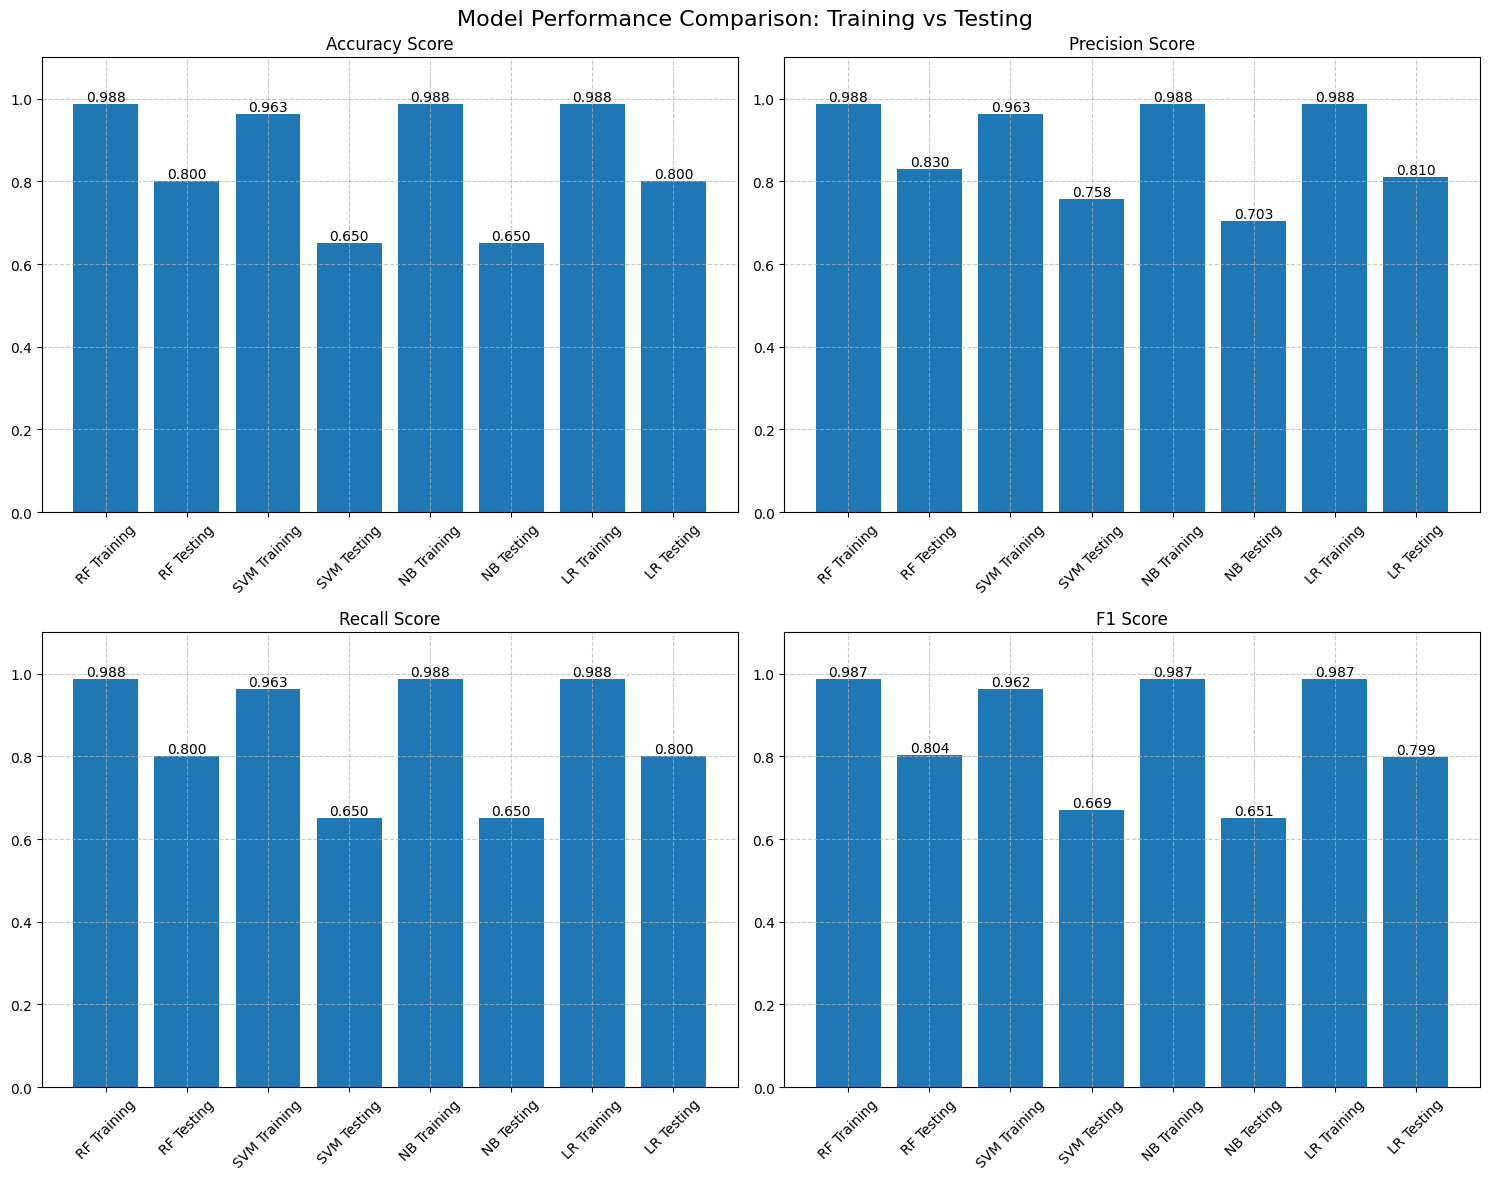

In [2]:
print("\n=== Overfitting Analysis ===")
rf_metrics = calculate_metrics(rf_classifier, X_train_rf, X_test_rf, y_train, y_test)
svm_metrics = calculate_metrics(svm_classifier, X_train_svm, X_test_svm, y_train, y_test)
nb_metrics = calculate_metrics(nb_classifier, X_train_nb, X_test_nb, y_train, y_test)
lr_metrics = calculate_metrics(lr_classifier, X_train_lr, X_test_lr, y_train, y_test)

rf_overfitting = calculate_overfitting_metrics(rf_metrics['train'], rf_metrics['test'])
svm_overfitting = calculate_overfitting_metrics(svm_metrics['train'], svm_metrics['test'])
nb_overfitting = calculate_overfitting_metrics(nb_metrics['train'], nb_metrics['test'])
lr_overfitting = calculate_overfitting_metrics(lr_metrics['train'], lr_metrics['test'])

print("\nOverfitting % (Train-Test)/Train:")
print("Metric     Random Forest  SVM  Naive Bayes   LR")
print("-" * 65)
for metric in rf_overfitting.keys():
    print(f"{metric:<10} {rf_overfitting[metric]:>8.2f}%  {svm_overfitting[metric]:>8.2f}%  {nb_overfitting[metric]:>8.2f}%  {lr_overfitting[metric]:>8.2f}%")

fig = plot_metrics_comparison(rf_metrics, svm_metrics, nb_metrics, lr_metrics)
plt.show()
fig.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

In [ ]:
print("\n=== Overfitting Analysis ===")
rf_metrics = calculate_metrics(rf_classifier, X_train_rf, X_test_rf, y_train, y_test)
svm_metrics = calculate_metrics(svm_classifier, X_train_svm, X_test_svm, y_train, y_test)

rf_overfitting = calculate_overfitting_metrics(rf_metrics['train'], rf_metrics['test'])
svm_overfitting = calculate_overfitting_metrics(svm_metrics['train'], svm_metrics['test'])

print("\nOverfitting % (Train-Test)/Train:")
print("Metric      Random Forest    SVM")
print("-" * 35)
for metric in rf_overfitting.keys():
    print(f"{metric:<10} {rf_overfitting[metric]:>8.2f}%  {svm_overfitting[metric]:>8.2f}%")

fig = plot_metrics_comparison(rf_metrics, svm_metrics)
plt.show()
fig.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

In [3]:
lr_vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),  
    min_df=2,  
    max_df=0.95,
    strip_accents='unicode',
    sublinear_tf=True
)

query = input()
print(query)
query = preprocess_text(query)

lr_vectorizer.fit(train_data['Query'])
query_vec_lr = lr_vectorizer.transform([query])

tfidf_df = pd.DataFrame(query_vec_lr.toarray())

print("Logistic Regression TF-IDF : ")
print(query_vec_lr)

apa kegunaan sanmol?
Logistic Regression TF-IDF : 
  (0, 51)	1.0


In [22]:
lr_vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),  
    min_df=2,  
    max_df=0.95,
    strip_accents='unicode',
    sublinear_tf=True
)

lr_vectorizer.fit(train_data['Query'])
tfidf_matrix = nb_vectorizer.transform(train_data['Query'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray())

print("Logistic Regression TF-IDF : ")
print(tfidf_df)

Logistic Regression TF-IDF : 
    0    1    2    3    4    5    6    7    8    9    ...  302  303  304  305  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
96  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
97  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
98  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
99  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  